# Introduction

# Task

### Pre-defined code

In [ ]:
!pip install -q natsort

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
style.use('ggplot')

In [3]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('ES666CV/images/A/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 4/4 [00:00<00:00, 67.37it/s]


In [4]:
def show_image_grid(images, M, N, title='Title'):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    fig, axes = plt.subplots(M, N, figsize=(N * 2, M * 2))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

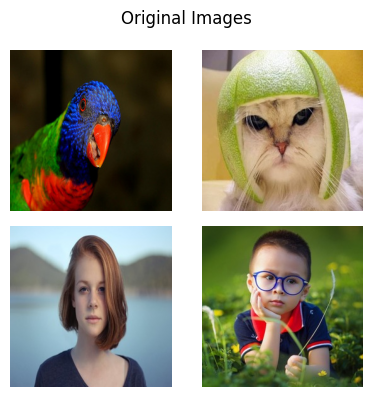

In [5]:
show_image_grid(gt_images, 2, 2, 'Original Images')

### Q1 [2 Marks]

Given some set of images, you have to add two different kind of noises to it.
* Impulse noise (Salt and Pepper noise)
* Gaussian noise

<br/>
<b>Note: Implement all the noise addition algorithm from scratch.</b> You can use numpy library for convolution and other methods.
<br/><br/>
Add noises in small amount so that not all the information in image is changes.
<br/><br/>
Also please vary the parameters of noise and display images accordingly.

In [ ]:
def add_impulse_noise(image, noise_prob):
    noisy_image = np.copy(image)

    M, N = image.shape[0], image.shape[1]
    random_mask = np.random.rand(M, N)

    noisy_image[random_mask < (noise_prob / 2)] = 255
    noisy_image[random_mask > (1 - noise_prob / 2)] = 0
    noisy_image = noisy_image.astype(np.uint8)

    return noisy_image

def add_gaussian_noise(image, mean, std):
    gaussian_noise = np.random.normal(mean, std, image.shape).astype(np.int16)
    noisy_image = image.astype(np.int16) + gaussian_noise
    noisy_image = np.clip(noisy_image, 0, 255)
    noisy_image = noisy_image.astype(np.uint8)
    return noisy_image

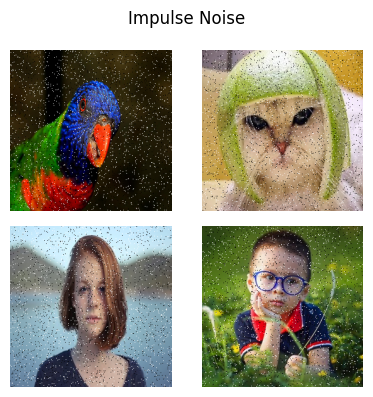

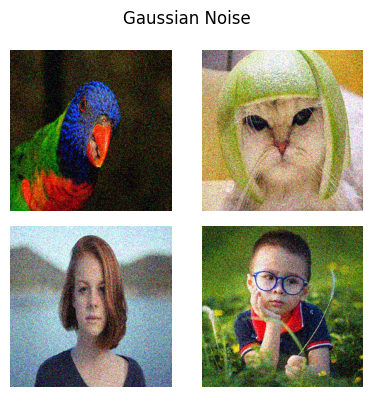

In [ ]:
# Write code here
impulse_noisy_images  = []
gaussian_noisy_images = []

# Write code here for variation in noise parameter

for image in gt_images:
    impulse_noisy_images.append(add_impulse_noise(image, noise_prob=0.05))
    gaussian_noisy_images.append(add_gaussian_noise(image, mean=0., std=30))

impulse_noisy_images = np.array(impulse_noisy_images)
gaussian_noisy_images = np.array(gaussian_noisy_images)

show_image_grid(impulse_noisy_images, M=2, N=2, title='Impulse Noise')
show_image_grid(gaussian_noisy_images, M=2, N=2, title='Gaussian Noise')

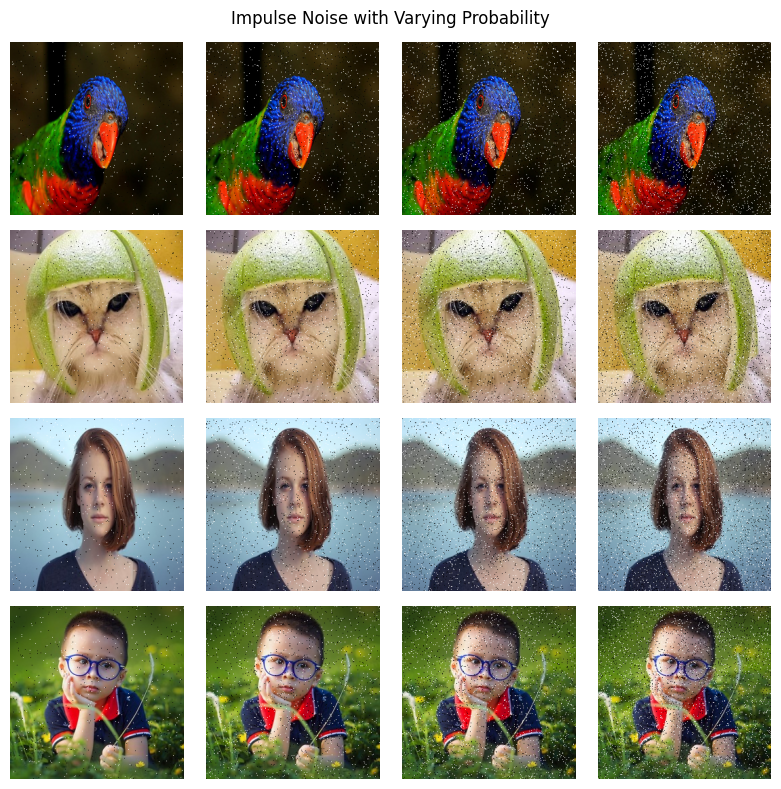

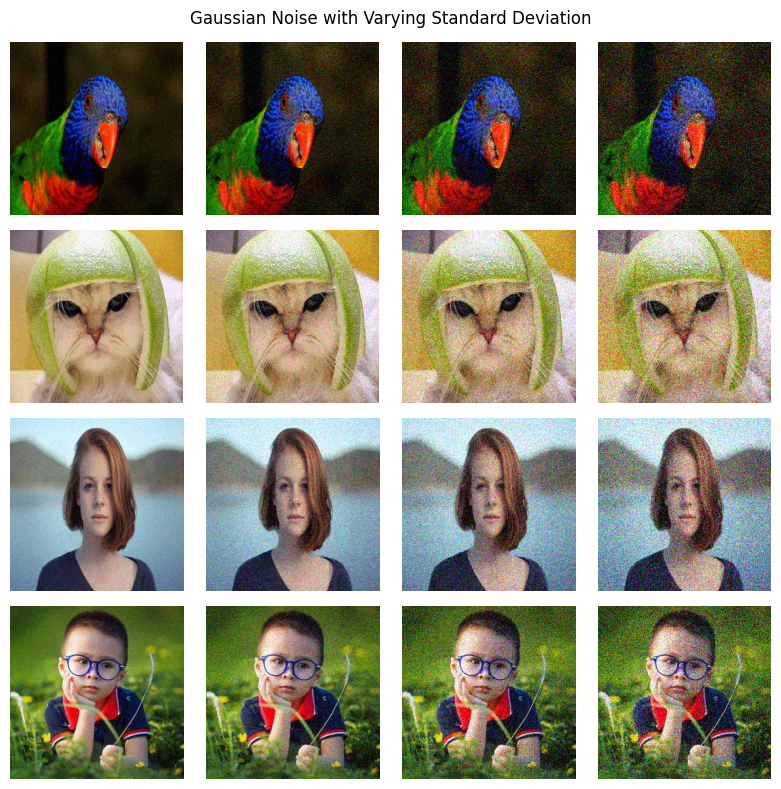

In [ ]:
impulse_noisy_images_var = []
gaussian_noisy_images_var = []

impulse_noise_probs = [0.01, 0.03, 0.05, 0.07]
gaussian_noise_stds = [10, 20, 30, 40]

num_images = len(gt_images)

for i, image in enumerate(gt_images):
    for j in range(4):
      noise_prob = impulse_noise_probs[j]
      std_dev = gaussian_noise_stds[j]

      impulse_noisy_images_var.append(add_impulse_noise(image, noise_prob=noise_prob))
      gaussian_noisy_images_var.append(add_gaussian_noise(image, mean=0., std=std_dev))

impulse_noisy_images_var = np.array(impulse_noisy_images_var)
gaussian_noisy_images_var = np.array(gaussian_noisy_images_var)

show_image_grid(impulse_noisy_images_var, M=4, N=4, title='Impulse Noise with Varying Probability')
show_image_grid(gaussian_noisy_images_var, M=4, N=4, title='Gaussian Noise with Varying Standard Deviation')

### Q2 [3 Marks]

Use three different filtering operations and denoise the noisy images generated in the previous question. You have to use following noises value for this and rest of the question.
<pre>
noise_prob: 0.05 (impulse noise)
gaussian noise: mean = 0, std = 30
</pre>

* Box Filter: Moving Average Filter

[![boxfilter.webp](https://i.postimg.cc/4NtD4Z7k/boxfilter.webp)](https://postimg.cc/9rm816YJ)

* Gaussian Filter

[![gaussian.png](https://i.postimg.cc/Kvy9NTzw/gaussian.png)](https://postimg.cc/NLp7G5Rk)

* Median Filter

[![median.png](https://i.postimg.cc/q704Hqj5/median.png)](https://postimg.cc/NKNW1sh6)



<b>Note: Implement all the filters algorithm from scratch.</b> You can use numpy library for convolution and other methods.

In [ ]:
import numpy as np
from numpy.fft import fft2, ifft2

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - size//2)**2 + (y - size//2)**2)/(2*sigma**2)), (size, size))
    return kernel/np.sum(kernel)

def median_filter(image, kernel_size):
    image_height, image_width, channels = image.shape
    kernal_height, kernal_width = kernel_size, kernel_size
    padding = kernal_height//2
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode='constant', constant_values=0)
    output_size = (image_height, image_width, channels)

    new_image = np.ones(output_size)
    for k in range(channels):
        for i in range(output_size[0]):
            for j in range(output_size[1]):
                new_image[i][j][k] = np.median(image[i:i+kernal_height, j:j+kernal_width, k])
    new_image = np.clip(new_image, 0, 255).astype(np.uint8)
    return new_image

def convolve2D_fft(image, kernel):
    image_height, image_width, channels = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = image_height - kernel_height
    pad_width = image_width - kernel_width
    kernel_padded = np.pad(kernel, ((0, pad_height), (0, pad_width)), mode='constant')

    new_image = np.zeros_like(image, dtype=np.float32)

    for k in range(channels):
        image_fft = fft2(image[:, :, k])
        kernel_fft = fft2(kernel_padded)

        convolved_fft = image_fft * kernel_fft

        convolved_image = np.real(ifft2(convolved_fft))

        new_image[:, :, k] = convolved_image[:image_height, :image_width]

    new_image = new_image/np.max(new_image)*255
    new_image = new_image.astype(np.uint8)
    return new_image

def gaussian_kernel(size, sigma):
    ax = np.arange(-(size // 2), size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

def apply_box_filter(image, kernel_size):
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    return convolve2D_fft(image, kernel)

def apply_gaussain_filter(image, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    return convolve2D_fft(image, kernel)

def apply_median_filter(image, kernel_size):
    return median_filter(image, kernel_size)


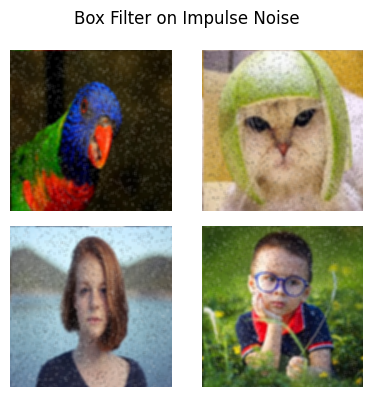

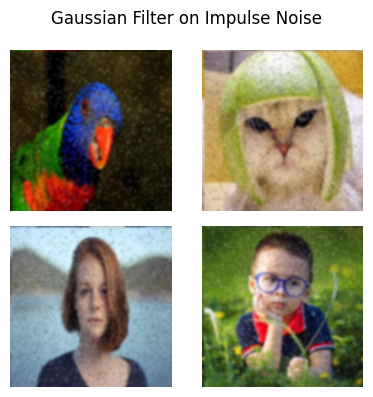

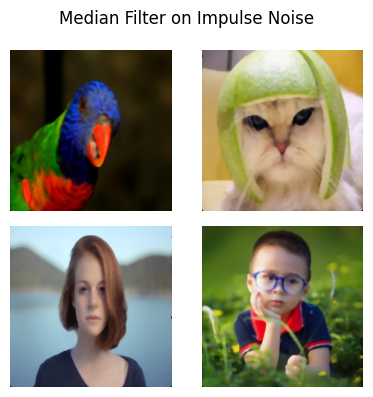

In [ ]:
# Write code here
box_filter_images_impulse       = []
gaussian_filter_images_impulse  = []
median_filter_images_impulse    = []

for image in impulse_noisy_images:
    box_filter_images_impulse.append(apply_box_filter(image, kernel_size=5))
    gaussian_filter_images_impulse.append(apply_gaussain_filter(image, kernel_size=7, sigma=2.0))
    median_filter_images_impulse.append(apply_median_filter(image, kernel_size=5))

box_filter_images_impulse = np.array(box_filter_images_impulse)
gaussian_filter_images_impulse = np.array(gaussian_filter_images_impulse)
median_filter_images_impulse = np.array(median_filter_images_impulse)

show_image_grid(box_filter_images_impulse, M=2, N=2, title='Box Filter on Impulse Noise')
show_image_grid(gaussian_filter_images_impulse, M=2, N=2, title='Gaussian Filter on Impulse Noise')
show_image_grid(median_filter_images_impulse, M=2, N=2, title='Median Filter on Impulse Noise')

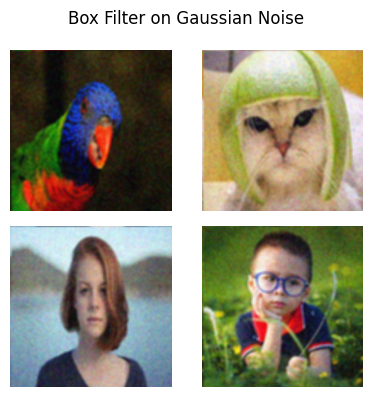

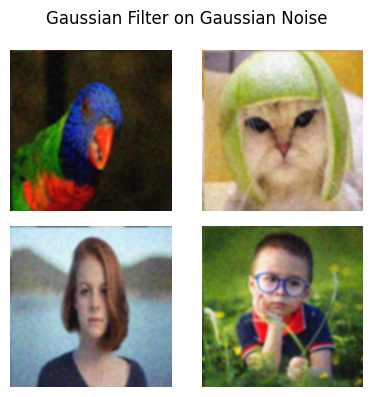

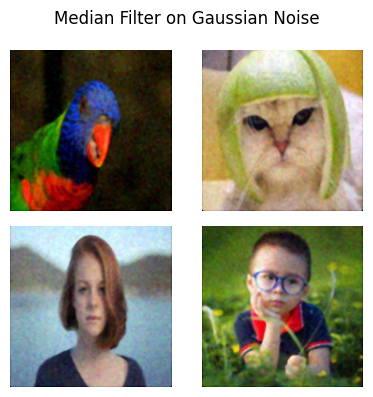

In [ ]:
# Write code here
box_filter_images_gaussian       = []
gaussian_filter_images_gaussian  = []
median_filter_images_gaussian    = []

for image in gaussian_noisy_images:
    box_filter_images_gaussian.append(apply_box_filter(image, kernel_size=5))
    gaussian_filter_images_gaussian.append(apply_gaussain_filter(image, kernel_size=7, sigma=2.0))
    median_filter_images_gaussian.append(apply_median_filter(image, kernel_size=5))

box_filter_images_gaussian = np.array(box_filter_images_gaussian)
gaussian_filter_images_gaussian = np.array(gaussian_filter_images_gaussian)
median_filter_images_gaussian = np.array(median_filter_images_gaussian)

show_image_grid(box_filter_images_gaussian, M=2, N=2, title='Box Filter on Gaussian Noise')
show_image_grid(gaussian_filter_images_gaussian, M=2, N=2, title='Gaussian Filter on Gaussian Noise')
show_image_grid(median_filter_images_gaussian, M=2, N=2, title='Median Filter on Gaussian Noise')

### Q3 [5 Marks]

Implement the Canny Edge Detector algorithm from scratch, you can use numpy library for computation operation such as convolution or sliding windows.
<br/>
Show canny edge results on the following denoised images from previous question:
* box_filter_images_impulse: [4, 256, 256, 3]
* gaussian_filter_images_impulse: [4, 256, 256, 3]
* median_filter_images_impulse: [4, 256, 256, 3]
* box_filter_images_gaussian: [4, 256, 256, 3]
* gaussian_filter_images_gaussian: [4, 256, 256, 3]
* median_filter_images_gaussian: [4, 256, 256, 3]

Total number of images in each of above array is: 4 <br/>
Each is of size H: 256, W: 256 and Channels: 3 <br/><br/>
Compare your implementation with Opencv canny edge detector method.<br/><br/>
Create a table of 6 x 4 (where 6 is all the filters and 4 is number of images) and show Root Mean Square Error between your canny edge image and opencv canny edge image.

In [ ]:
from numpy.fft import fft2, ifft2
from numpy import array, zeros, abs, sqrt, arctan2, arctan, pi, real
def rgb_to_grayscale(image):
    image = image.astype(np.float32)
    B = image[:, :, 0]
    G = image[:, :, 1]
    R = image[:, :, 2]

    gray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    return gray

def gaussian_filter(image):
    kernal = gaussian_kernel(5, np.sqrt(5.0))
    kernal = np.fft.fft2(kernal, s=image.shape)
    image_fft = np.fft.fft2(image)
    filtered_image = np.real(np.fft.ifft2(kernal * image_fft))
    return filtered_image

def sobel_filter(image):
    kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])


    kernal_x = np.zeros(image.shape)
    kernal_y = np.zeros(image.shape)

    kernal_x[:kx.shape[0], :kx.shape[1]] = kx
    kernal_y[:ky.shape[0], :ky.shape[1]] = ky

    kernal_x = np.fft.fft2(kernal_x)
    kernal_y = np.fft.fft2(kernal_y)
    image_fft = np.fft.fft2(image)

    gradient_x = np.real(np.fft.ifft2(kernal_x * image_fft))
    gradient_y = np.real(np.fft.ifft2(kernal_y * image_fft))

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2).astype(float)
    gradient_direction = (np.arctan2(gradient_y, gradient_x)*180/np.pi).astype(float)
    gradient_magnitude = gradient_magnitude/np.max(gradient_magnitude)*255

    return gradient_magnitude, gradient_direction


In [ ]:
def non_max_suppression(gradient_magnitude, gradient_direction):
    (image_height, image_width) = gradient_magnitude.shape
    new_image = np.zeros(gradient_magnitude.shape, dtype=np.float32)

    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            direction = gradient_direction[i][j]
            if direction < 0:
                direction += 360
            if (j+1 < new_image.shape[1] and ((j-1) >= 0) and ((i+1) < new_image.shape[0]) and ((i-1) >= 0)):
                if (direction >= 337.5 or direction < 22.5) or (direction >= 157.5 and direction < 202.5):
                    if (gradient_magnitude[i][j] >= gradient_magnitude[i][j+1]) and (gradient_magnitude[i][j] >= gradient_magnitude[i][j-1]):
                        new_image[i][j] = gradient_magnitude[i][j]
                elif (direction >= 22.5 and direction < 67.5) or (direction >= 202.5 and direction < 247.5):
                    if (gradient_magnitude[i][j] >= gradient_magnitude[i-1][j+1]) and (gradient_magnitude[i][j] >= gradient_magnitude[i+1][j-1]):
                        new_image[i][j] = gradient_magnitude[i][j]
                elif (direction >= 67.5 and direction < 112.5) or (direction >= 247.5 and direction < 292.5):
                    if (gradient_magnitude[i][j] >= gradient_magnitude[i-1][j]) and (gradient_magnitude[i][j] >= gradient_magnitude[i+1][j]):
                        new_image[i][j] = gradient_magnitude[i][j]
                elif (direction >= 112.5 and direction < 157.5) or (direction >= 292.5 and direction < 337.5):
                    if (gradient_magnitude[i][j] >= gradient_magnitude[i-1][j-1]) and (gradient_magnitude[i][j] >= gradient_magnitude[i+1][j+1]):
                        new_image[i][j] = gradient_magnitude[i][j]

    return new_image

def double_threshold(image, threshold1, threshold2, weak, strong):
    output = np.zeros(image.shape)
    strong_edges = []

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] >= threshold2:
                output[i][j] = strong
                strong_edges.append((i, j))
            elif image[i][j] >= threshold1:
                output[i][j] = weak
    return output, strong_edges

def edge_detection(image, strong_edges, weak):
    vis = np.zeros(image.shape, dtype=bool)
    dx = [1, 0, -1, 0, -1, -1, 1, 1]
    dy = [0, 1, 0, -1, 1, -1, 1, -1]
    for s in strong_edges:
        if not vis[s]:
            vis[s] = True
            image[s] = 255.0
            stack = [s]
            while len(stack) > 0:
                x, y = stack.pop()
                vis[x][y] = True
                image[x][y] = 255.0
                for i in range(len(dx)):
                    for c in range(1, 32):
                            nx, ny = x + c*dx[i], y + c*dy[i]
                            if nx >= 0 and nx < image.shape[0] and ny >= 0 and ny < image.shape[1]:
                                if image[nx][ny] >= weak and not vis[nx][ny]:
                                    stack.append((nx, ny))


    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if vis[i][j] == True:
                image[i][j] = 255.0
            else:
                image[i][j] = 0.0
    # image = image.astype(np.uint8)
    return image






In [ ]:
def gaussian_filter(image):
    kernal = gaussian_kernel(7, 5.5)
    kernal = np.fft.fft2(kernal, s=image.shape)
    image_fft = np.fft.fft2(image)
    filtered_image = np.real(np.fft.ifft2(kernal * image_fft))
    return filtered_image

In [ ]:
threshold1 = 80
threshold2 = 180

In [ ]:
def apply_canny_edge_detector_opencv(image, threshold1, threshold2):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply the Canny edge detector
    edges = cv2.Canny(gray_image, threshold1, threshold2)
    # This is done only for converting 1 channel image to 3 channels for
    # visualization purpose in matplotlib
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges

def apply_canny_edge_detector_self(image, threshold1, threshold2, flag=False):
    gray_image = rgb_to_grayscale(image)
    gray_image = gaussian_filter(gray_image)
    gradient_magnitude, gradient_direction = sobel_filter(gray_image)
    non_max_suppressed_image = non_max_suppression(gradient_magnitude, gradient_direction)
    thresholded_image, strong_edges = double_threshold(non_max_suppressed_image, threshold1, threshold2, threshold2, 255)
    edges = edge_detection(thresholded_image,strong_edges, threshold2)
    edges = edges.astype(np.uint8)
    # This is done only for converting 1 channel image to 3 channels for
    # visualization purpose in matplotlib
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    return edges

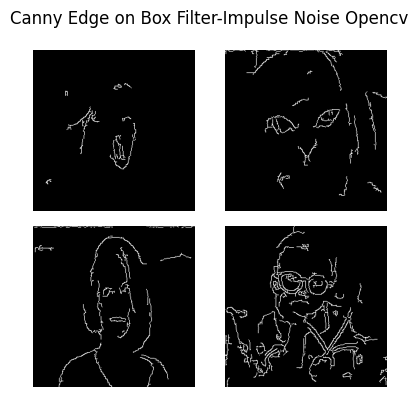

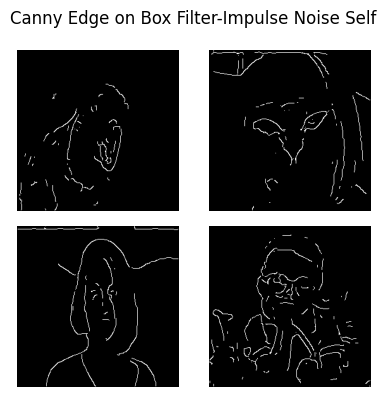

In [ ]:
canny_edge_opencv_box_filter_images_impulse = []
canny_edge_self_box_filter_images_impulse = []

for image in box_filter_images_impulse:
    canny_edge_opencv_box_filter_images_impulse.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_box_filter_images_impulse.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_opencv_box_filter_images_impulse = np.array(canny_edge_opencv_box_filter_images_impulse)
canny_edge_self_box_filter_images_impulse = np.array(canny_edge_self_box_filter_images_impulse)

show_image_grid(canny_edge_opencv_box_filter_images_impulse, M=2, N=2, title='Canny Edge on Box Filter-Impulse Noise Opencv')
show_image_grid(canny_edge_self_box_filter_images_impulse, M=2, N=2, title='Canny Edge on Box Filter-Impulse Noise Self')

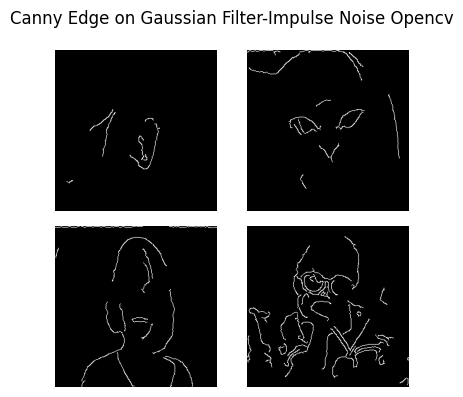

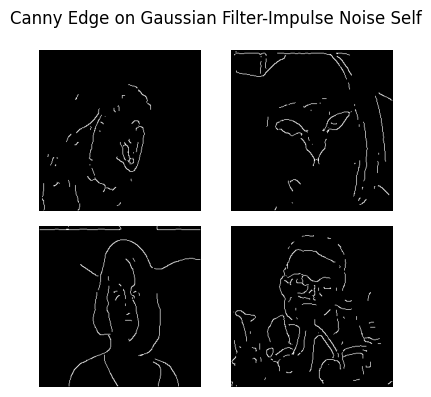

In [ ]:
canny_edge_opencv_gaussian_filter_images_impulse = []
canny_edge_self_gaussian_filter_images_impulse = []

for image in gaussian_filter_images_impulse:
    canny_edge_opencv_gaussian_filter_images_impulse.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_gaussian_filter_images_impulse.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_opencv_gaussian_filter_images_impulse = np.array(canny_edge_opencv_gaussian_filter_images_impulse)
canny_edge_self_gaussian_filter_images_impulse = np.array(canny_edge_self_gaussian_filter_images_impulse)

show_image_grid(canny_edge_opencv_gaussian_filter_images_impulse, M=2, N=2, title='Canny Edge on Gaussian Filter-Impulse Noise Opencv')
show_image_grid(canny_edge_self_gaussian_filter_images_impulse, M=2, N=2, title='Canny Edge on Gaussian Filter-Impulse Noise Self')

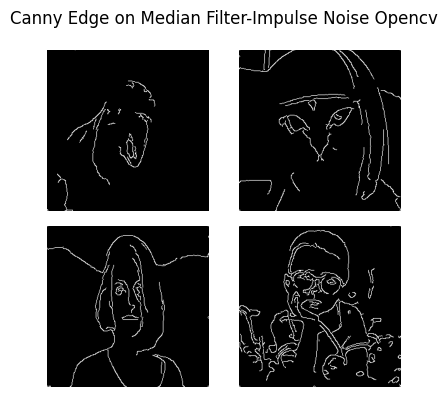

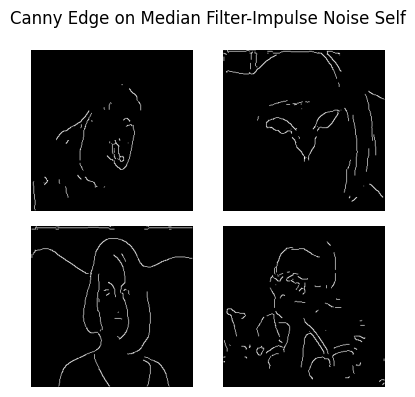

In [ ]:
canny_edge_opencv_median_filter_images_impulse = []
canny_edge_self_median_filter_images_impulse = []

for image in median_filter_images_impulse:
    canny_edge_opencv_median_filter_images_impulse.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_median_filter_images_impulse.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_opencv_median_filter_images_impulse = np.array(canny_edge_opencv_median_filter_images_impulse)
canny_edge_self_median_filter_images_impulse = np.array(canny_edge_self_median_filter_images_impulse)

show_image_grid(canny_edge_opencv_median_filter_images_impulse, M=2, N=2, title='Canny Edge on Median Filter-Impulse Noise Opencv')
show_image_grid(canny_edge_self_median_filter_images_impulse, M=2, N=2, title='Canny Edge on Median Filter-Impulse Noise Self')

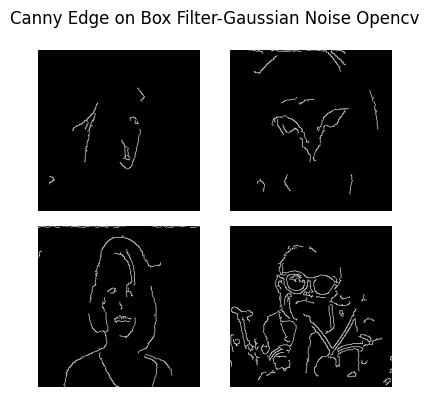

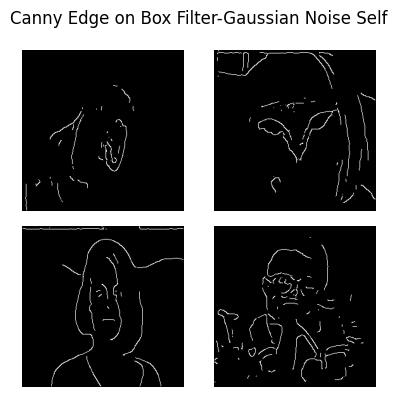

In [ ]:
canny_edge_opencv_box_filter_images_gaussian = []
canny_edge_self_box_filter_images_gaussian = []

for image in box_filter_images_gaussian:
    canny_edge_opencv_box_filter_images_gaussian.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_box_filter_images_gaussian.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_opencv_box_filter_images_gaussian = np.array(canny_edge_opencv_box_filter_images_gaussian)
canny_edge_self_box_filter_images_gaussian = np.array(canny_edge_self_box_filter_images_gaussian)

show_image_grid(canny_edge_opencv_box_filter_images_gaussian, M=2, N=2, title='Canny Edge on Box Filter-Gaussian Noise Opencv')
show_image_grid(canny_edge_self_box_filter_images_gaussian, M=2, N=2, title='Canny Edge on Box Filter-Gaussian Noise Self')

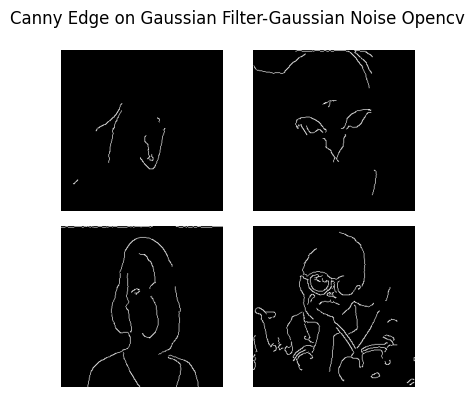

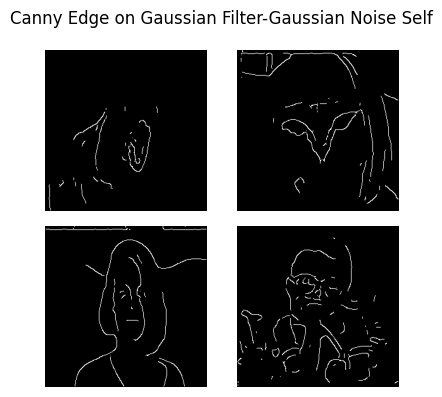

In [ ]:
canny_edge_opencv_gaussian_filter_images_gaussian = []
canny_edge_self_gaussian_filter_images_gaussian = []

for image in gaussian_filter_images_gaussian:
    canny_edge_opencv_gaussian_filter_images_gaussian.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_gaussian_filter_images_gaussian.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_opencv_gaussian_filter_images_gaussian = np.array(canny_edge_opencv_gaussian_filter_images_gaussian)
canny_edge_self_gaussian_filter_images_gaussian = np.array(canny_edge_self_gaussian_filter_images_gaussian)

show_image_grid(canny_edge_opencv_gaussian_filter_images_gaussian, M=2, N=2, title='Canny Edge on Gaussian Filter-Gaussian Noise Opencv')
show_image_grid(canny_edge_self_gaussian_filter_images_gaussian, M=2, N=2, title='Canny Edge on Gaussian Filter-Gaussian Noise Self')

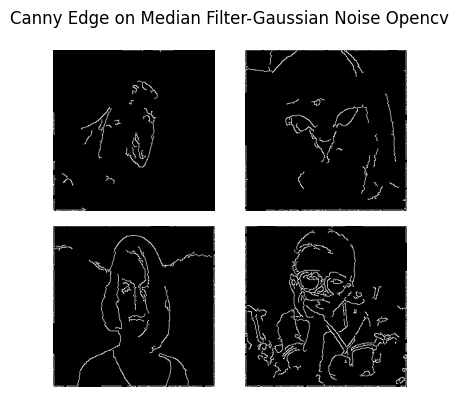

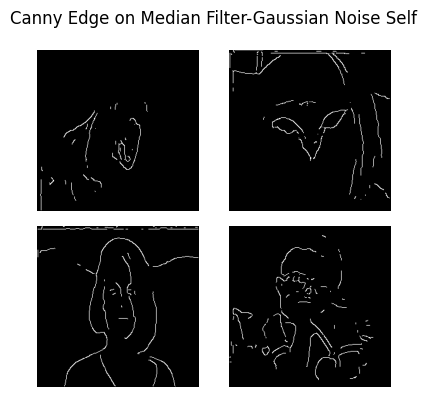

In [ ]:
canny_edge_opencv_median_filter_images_gaussian = []
canny_edge_self_median_filter_images_gaussian = []

for image in median_filter_images_gaussian:
    canny_edge_opencv_median_filter_images_gaussian.append(apply_canny_edge_detector_opencv(image, threshold1=threshold1, threshold2=threshold2))
    canny_edge_self_median_filter_images_gaussian.append(apply_canny_edge_detector_self(image, threshold1=threshold1, threshold2=threshold2))

canny_edge_opencv_median_filter_images_gaussian = np.array(canny_edge_opencv_median_filter_images_gaussian)
canny_edge_self_median_filter_images_gaussian = np.array(canny_edge_self_median_filter_images_gaussian)

show_image_grid(canny_edge_opencv_median_filter_images_gaussian, M=2, N=2, title='Canny Edge on Median Filter-Gaussian Noise Opencv')
show_image_grid(canny_edge_self_median_filter_images_gaussian, M=2, N=2, title='Canny Edge on Median Filter-Gaussian Noise Self')

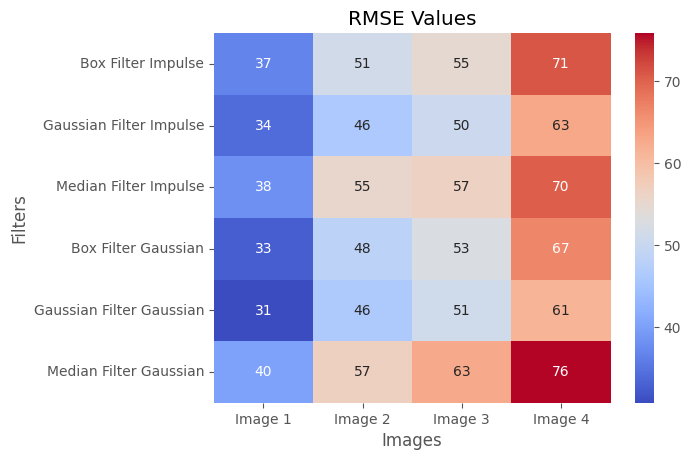

In [ ]:
####
# RMSE table of size 6 x 4
###


import seaborn as sns
rmse_table = np.zeros((6, 4))

def rmse(image1, image2):

    return np.sqrt(np.mean((image1.astype(np.float32) - image2.astype(np.float32))**2), dtype=np.float32)

# Box Filter Impulse Noise
for i in range(4):
    rmse_table[0][i] = rmse(canny_edge_opencv_box_filter_images_impulse[i], canny_edge_self_box_filter_images_impulse[i])
for i in range(4):
    rmse_table[1][i] = rmse(canny_edge_opencv_gaussian_filter_images_impulse[i], canny_edge_self_gaussian_filter_images_impulse[i])
for i in range(4):
    rmse_table[2][i] = rmse(canny_edge_opencv_median_filter_images_impulse[i], canny_edge_self_median_filter_images_impulse[i])
for i in range(4):
    rmse_table[3][i] = rmse(canny_edge_opencv_box_filter_images_gaussian[i], canny_edge_self_box_filter_images_gaussian[i])
for i in range(4):
    rmse_table[4][i] = rmse(canny_edge_opencv_gaussian_filter_images_gaussian[i], canny_edge_self_gaussian_filter_images_gaussian[i])
for i in range(4):
    rmse_table[5][i] = rmse(canny_edge_opencv_median_filter_images_gaussian[i], canny_edge_self_median_filter_images_gaussian[i])

sns.heatmap(rmse_table, annot=True, cmap='coolwarm', xticklabels=['Image 1', 'Image 2', 'Image 3', 'Image 4'], yticklabels=['Box Filter Impulse', 'Gaussian Filter Impulse', 'Median Filter Impulse', 'Box Filter Gaussian', 'Gaussian Filter Gaussian', 'Median Filter Gaussian'])
plt.xlabel('Images')
plt.ylabel('Filters')
plt.title('RMSE Values')
plt.show()
